In [1]:
import astropy.units as u
import astropy.constants as c
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import sys 
sys.path.append('/Users/clairewilliams/opt/anaconda3/lib/python3.9/site-packages')
sys.path.append('../../model-timescales/src')
import pandas
from timescales.data import build_bulk_energy_grid
from timescales import TimescaleEnsemble
from timescales.analysis.model import create_dynamical_model

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(71,0.27,Ob0=0.044, Tcmb0=2.726 *u.K)

In [2]:
masses_array   = np.logspace(4, 8, 10) * u.Msun
radii_array    = np.logspace(-0.7, 2, 10) * u.pc
velocity_array = np.logspace(-0.7, 2.2, 10) * u.km/u.s

grid = build_bulk_energy_grid(masses_array, radii_array, velocity_array,
                              alpha=3/5, energy_unit=u.erg)


# Example: access aligned arrays
M = grid['M']   # Msun
R = grid['R']   # pc
V = grid['V']   # km/s
K = grid['K']   # erg
U = grid['U']   # erg

print(len(M), len(R), len(V), len(K), len(U))  # -> 1_000_000 each (100*100*100

167 167 167 167 167


In [3]:
ensemble = TimescaleEnsemble(grid, 
                    densityModel="power-law-bh",
                    Nsampling = 300,
                    timescales_kwargs={'cosmology':cosmo},
                    profile_kwargs={"alpha":1.75, "M_bh":1e5*u.Msun})

Using power-law-bh model with properties:
alpha=1.75
M_bh=100000.0 solMass
Using parameters for timescale evaluation
cosmology=FlatLambdaCDM(H0=71.0 km / (Mpc s), Om0=0.27, Tcmb0=2.726 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.044)
No imf arguments given. Defaulting to 'salpeter'.


In [4]:
model = create_dynamical_model(ensemble)

will use defaults for  {'e': 0.0, 'Mcollisions': <Quantity 1. solMass>, 'n_unit': <Quantity 1. 1 / cm3>, 'v_unit': Unit("cm / s"), 'Mstar_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Using default z = 12 since no redshift provided
Using nearest neighbor for interaction type.


/Users/clairewilliams/Research/Calculations/timescale-plots/models/../../model-timescales/src/timescales/physics/halo_environment.py:135: RuntimeWarning: invalid value encountered in divide
  normalization_offset = stfunction17/stfunction


collisions occur in 102 systems


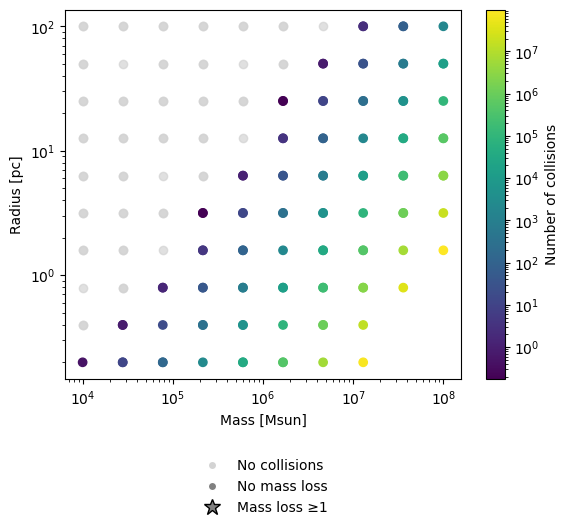

In [15]:

x = model['mass'] * u.Msun
y = model['radius'] * u.pc
c = np.array(model['N_collisions'])
mflag = np.array(model['N_collisions_massloss'])  # new flag array

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Mask zeros for log-scaling
c_masked = np.ma.masked_equal(c, 0)
norm = mcolors.LogNorm(vmin=c_masked.min(), vmax=c_masked.max())
cmap = plt.cm.viridis

# --- Separate the two populations by shape ---
mask_star = mflag >= 1   # star markers
mask_circle = ~mask_star # circle markers
# Add explicit grey points for zeros
ax.scatter(x[c == 0], y[c == 0], color="lightgrey", marker='o', alpha=0.7, label="0 collisions")

# Plot circles (no mass loss)
sc1 = ax.scatter(x[mask_circle], y[mask_circle], 
                 c=np.ma.masked_equal(c[mask_circle], 0), 
                 cmap=cmap, norm=norm, marker='o')

# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='*', s=120, edgecolor='k')


# --- Colorbar ---
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label("Number of collisions")

# Add legend for shapes
legend_handles = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='lightgrey',
               label='No collisions'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='gray',
               label='No mass loss'),
    plt.Line2D([], [], marker='*', color='w', markerfacecolor='gray',
               markeredgecolor='k', markersize=12, label='Mass loss ≥1')
]

ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    frameon=False
)
ax.set_xlabel("Mass [Msun]")
ax.set_ylabel("Radius [pc]")

plt.show()


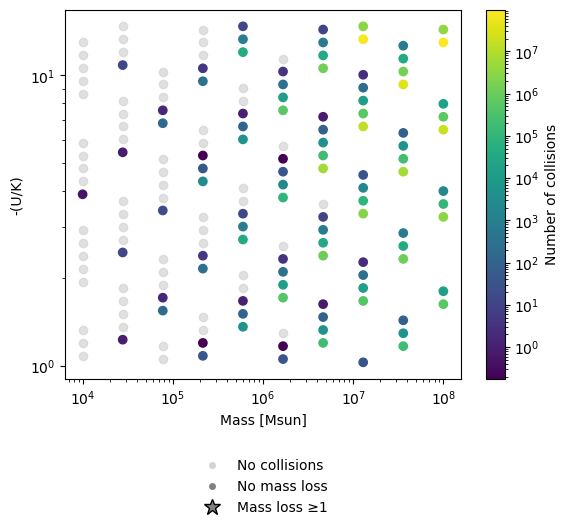

In [10]:

x = model['mass'] * u.Msun
y = -np.array(model['potential']*u.erg)/np.array(model['kinetic']*u.erg)
c = np.array(model['N_collisions'])

mflag = np.array(model['N_collisions_massloss'])  # new flag array

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Mask zeros for log-scaling
c_masked = np.ma.masked_equal(c, 0)
norm = mcolors.LogNorm(vmin=c_masked.min(), vmax=c_masked.max())
cmap = plt.cm.viridis

# --- Separate the two populations by shape ---
mask_star = mflag >= 1   # star markers
mask_circle = ~mask_star # circle markers

# Plot circles (no mass loss)
sc1 = ax.scatter(x[mask_circle], y[mask_circle], 
                 c=np.ma.masked_equal(c[mask_circle], 0), 
                 cmap=cmap, norm=norm, marker='o')

# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='*', s=120, edgecolor='k')

# Add explicit grey points for zeros
ax.scatter(x[c == 0], y[c == 0], color="lightgrey", marker='o', alpha=0.7, label="0 collisions")

# --- Colorbar ---
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label("Number of collisions")

# Add legend for shapes
legend_handles = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='lightgrey',
               label='No collisions'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='gray',
               label='No mass loss'),
    plt.Line2D([], [], marker='*', color='w', markerfacecolor='gray',
               markeredgecolor='k', markersize=12, label='Mass loss ≥1')
]

ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    frameon=False
)
ax.set_xlabel("Mass [Msun]")
ax.set_ylabel("-(U/K)")

plt.show()



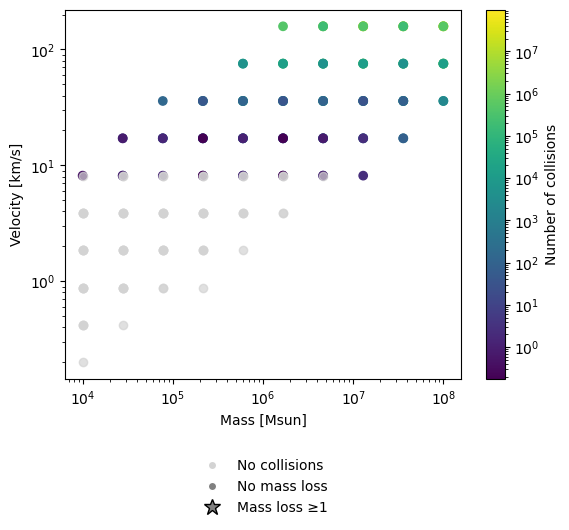

In [11]:


x = model['mass'] * u.Msun
y = model['velocity'] * (u.km/u.s)
c = np.array(model['N_collisions'])
mflag = np.array(model['N_collisions_massloss'])  # new flag array

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Mask zeros for log-scaling
c_masked = np.ma.masked_equal(c, 0)
norm = mcolors.LogNorm(vmin=c_masked.min(), vmax=c_masked.max())
cmap = plt.cm.viridis

# --- Separate the two populations by shape ---
mask_star = mflag >= 1   # star markers
mask_circle = ~mask_star # circle markers

# Plot circles (no mass loss)
sc1 = ax.scatter(x[mask_circle], y[mask_circle], 
                 c=np.ma.masked_equal(c[mask_circle], 0), 
                 cmap=cmap, norm=norm, marker='o')

# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='*', s=120, edgecolor='k')

# Add explicit grey points for zeros
ax.scatter(x[c == 0], y[c == 0], color="lightgrey", marker='o', alpha=0.7, label="0 collisions")

# --- Colorbar ---
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label("Number of collisions")

# Add legend for shapes
legend_handles = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='lightgrey',
               label='No collisions'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='gray',
               label='No mass loss'),
    plt.Line2D([], [], marker='*', color='w', markerfacecolor='gray',
               markeredgecolor='k', markersize=12, label='Mass loss ≥1')
]

ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    frameon=False
)
ax.set_xlabel("Mass [Msun]")
ax.set_ylabel("Velocity [km/s]")

plt.show()


In [12]:
mask_star

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [13]:
pandas.DataFrame(model)

,mass,radius,velocity,kinetic,potential,t_ms,t_merger,coll_occur_within_tmin,N_collisions,N_collisions_massloss
0,10000.0 solMass,0.19952623149688797 pc,8.149127469020744 km / s,6.602343823904421e+48 erg,-2.571687829305563e+49 erg,10000000000.0 yr,132059728.3342464 yr,True,0.464327,0
1,10000.0 solMass,0.3981071705534973 pc,3.8805107322101837 km / s,1.497109935253002e+48 erg,-1.2888971089225797e+49 erg,10000000000.0 yr,131297499.70918445 yr,False,0.000000,0
2,10000.0 solMass,0.3981071705534973 pc,8.149127469020744 km / s,6.602343823904421e+48 erg,-1.2888971089225797e+49 erg,10000000000.0 yr,131297499.70918445 yr,False,0.000000,0
3,10000.0 solMass,0.7943282347242817 pc,3.8805107322101837 km / s,1.497109935253002e+48 erg,-6.459787764510967e+48 erg,10000000000.0 yr,129796241.54378136 yr,False,0.000000,0
4,10000.0 solMass,1.584893192461114 pc,1.8478497974222916 km / s,3.3947613423558262e+47 erg,-3.237563159514553e+48 erg,10000000000.0 yr,126876765.9779066 yr,False,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
162,100000000.0 solMass,12.589254117941682 pc,158.48931924611142 km / s,2.4973298872430784e+55 erg,-4.075850533801482e+55 erg,10000000000.0 yr,3665023867.6096 yr,True,527106.157616,0
163,100000000.0 solMass,25.118864315095834 pc,75.47059566968908 km / s,5.662803218849747e+54 erg,-2.042764253714205e+55 erg,10000000000.0 yr,3536494601.201918 yr,True,96487.528983,0
164,100000000.0 solMass,50.11872336272727 pc,35.938136638046274 km / s,1.2840650512061779e+54 erg,-1.023807365271702e+55 erg,10000000000.0 yr,3299453342.28117 yr,True,14717.357299,0
165,100000000.0 solMass,50.11872336272727 pc,75.47059566968908 km / s,5.662803218849747e+54 erg,-1.023807365271702e+55 erg,10000000000.0 yr,3299453342.28117 yr,True,14428.750679,0
